In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

np.random.seed(2)

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
import keras.optimizers as opt
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers.core import Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers import Input
print(2)

2


In [3]:
data = pd.read_csv("fer2013.csv")
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
groups = [g for _, g in data.groupby('Usage')]
train = groups[2]
val = groups[1]
test = groups[0]

In [5]:
train = train.drop(labels=['Usage'], axis=1)
val = val.drop(labels=['Usage'], axis=1)
test = test.drop(labels=['Usage'], axis=1)

Y_train = train["emotion"]
Y_val = val["emotion"]
Y_test = test["emotion"]
#'Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'#

X_train = train["pixels"]
X_val = val["pixels"]
X_test = test["pixels"]
print(5)

5


In [6]:
def preprocess(X):
    X = np.array([np.fromstring(image, np.uint8, sep=' ') for image in X])
    X = X/255.0
    X = X.reshape(-1, 48, 48, 1)
    return X

In [7]:
X_train = preprocess(X_train)
X_val = preprocess(X_val)
X_test = preprocess(X_test)

Text(0.5,1,'Counts per emotion in testing set')

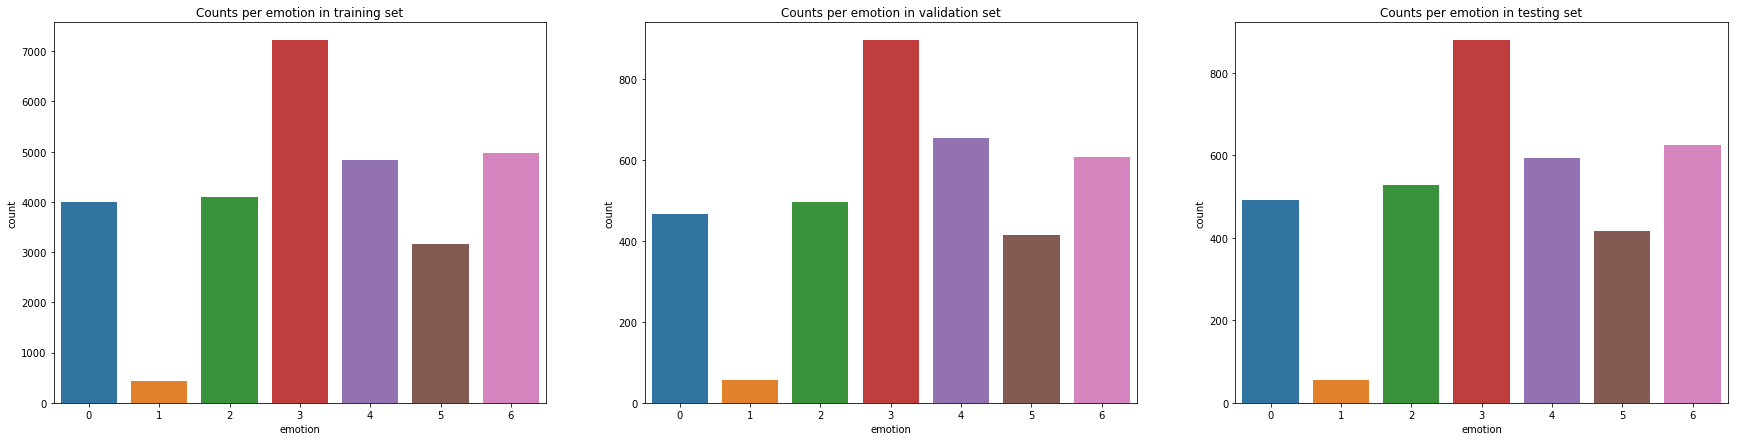

In [8]:
plt.figure(figsize=(30, 7))

plt.subplot(1,3,1)
ax = sns.countplot(Y_train)
ax.set(ylabel="count", xlabel="emotion")
plt.title("Counts per emotion in training set")

plt.subplot(1,3,2)
ax = sns.countplot(Y_val)
ax.set(ylabel="count", xlabel="emotion")
plt.title("Counts per emotion in validation set")

plt.subplot(1,3,3)
ax = sns.countplot(Y_test)
ax.set(ylabel="count", xlabel="emotion")
plt.title("Counts per emotion in testing set")

In [9]:
print("Is any label null in training set:", Y_train.isnull().any())
print("Is any label null in validation set:", Y_val.isnull().any())
print("Is any label null in testing set:", Y_test.isnull().any())


Y_train = to_categorical(Y_train, num_classes=7)
Y_val = to_categorical(Y_val, num_classes=7)
Y_test = to_categorical(Y_test, num_classes=7)

Is any label null in training set: False
Is any label null in validation set: False
Is any label null in testing set: False


In [10]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding="Same", activation='relu', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Conv2D(32, (5,5), padding="Same", activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(64, (3,3), padding="Same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (5,5), padding="Same", activation='relu'))
model.add(MaxPooling2D((2,2))) 
model.add(Dropout(0.5))
model.add(Conv2D(128, (3,3), padding="Same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (5,5), padding="Same", activation='relu'))
model.add(MaxPooling2D((2,2))) 
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='softmax'))
print(5)

5


In [11]:
optimizer = opt.Adam(lr = 0.001)
lr_anneal = ReduceLROnPlateau(monitor = 'val_accuracy', patience=3, factor=0.2, min_lr=1e-6)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 64)        2

In [27]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=80, batch_size = 64, callbacks=[lr_anneal])

Epoch 1/80
449/449 [==============================] - 427s 951ms/step - loss: 2.5777 - accuracy: 0.2457 - val_loss: 1.7122 - val_accuracy: 0.3023
Epoch 2/80
449/449 [==============================] - 397s 885ms/step - loss: 1.5795 - accuracy: 0.3748 - val_loss: 1.4446 - val_accuracy: 0.4344
Epoch 3/80
449/449 [==============================] - 395s 879ms/step - loss: 1.3966 - accuracy: 0.4534 - val_loss: 1.3317 - val_accuracy: 0.4804
Epoch 4/80
449/449 [==============================] - 400s 891ms/step - loss: 1.2864 - accuracy: 0.4979 - val_loss: 1.2992 - val_accuracy: 0.4974
Epoch 5/80
449/449 [==============================] - 395s 881ms/step - loss: 1.2472 - accuracy: 0.5134 - val_loss: 1.2324 - val_accuracy: 0.5199
Epoch 6/80
449/449 [==============================] - 400s 891ms/step - loss: 1.2106 - accuracy: 0.5224 - val_loss: 1.3085 - val_accuracy: 0.4937
Epoch 7/80
449/449 [==============================] - 398s 886ms/step - loss: 1.1840 - accuracy: 0.5449 - val_loss: 1.2479 -

Epoch 57/80
449/449 [==============================] - 389s 866ms/step - loss: 0.5898 - accuracy: 0.7781 - val_loss: 1.1441 - val_accuracy: 0.6503
Epoch 58/80
449/449 [==============================] - 389s 865ms/step - loss: 0.6061 - accuracy: 0.7753 - val_loss: 1.1423 - val_accuracy: 0.6503
Epoch 59/80
449/449 [==============================] - 381s 849ms/step - loss: 0.5897 - accuracy: 0.7861 - val_loss: 1.1441 - val_accuracy: 0.6498
Epoch 60/80
449/449 [==============================] - 377s 841ms/step - loss: 0.5906 - accuracy: 0.7815 - val_loss: 1.1448 - val_accuracy: 0.6503
Epoch 61/80
449/449 [==============================] - 376s 837ms/step - loss: 0.6058 - accuracy: 0.7764 - val_loss: 1.1446 - val_accuracy: 0.6489
Epoch 62/80
449/449 [==============================] - 378s 842ms/step - loss: 0.5931 - accuracy: 0.7757 - val_loss: 1.1447 - val_accuracy: 0.6503
Epoch 63/80
449/449 [==============================] - 380s 846ms/step - loss: 0.5931 - accuracy: 0.7819 - val_loss: 1

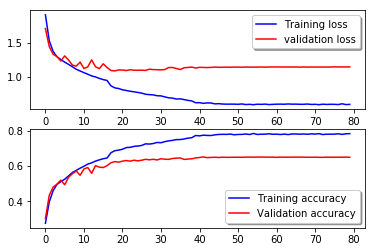

In [30]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

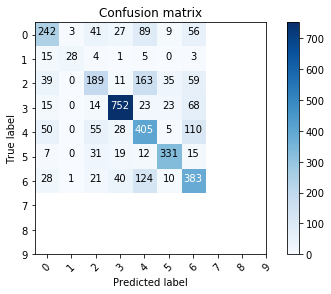

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [33]:
score, acc = model.evaluate(X_test, Y_test, batch_size=100)
print('Test score:', score)
print("Test accuracy:", acc)

36/36 [==============================] - 7s 203ms/step - loss: 1.1096 - accuracy: 0.6587
Test score: 1.1095701456069946
Test accuracy: 0.6586793065071106


In [34]:
model_json = model.to_json()
with open("emomodel.json", "w") as json_file:
   json_file.write(model_json)
model.save_weights("emomodel.h5")
print("Saved model to disk")

Saved model to disk


In [13]:
import os
import cv2
import numpy as np
from keras.models import model_from_json
from keras.preprocessing import image

In [14]:
model = model_from_json(open("emomodel.json", "r").read())
model.load_weights('emomodel.h5')
face_haar_cascade = cv2.CascadeClassifier(r'F:\ronil be project\project\facial emotion\haarcascade_frontalface_default.xml')
print(5)
model.save("emomodel.h5")

5


In [15]:
from keras.models import load_model
from time import sleep
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image
import cv2
import numpy as np
import os
print(5)
classifier =load_model('emomodel.h5')

5


In [ ]:
class_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
cap=cv2.VideoCapture(0)

while True:
    ret, image = cap.read()

    converted_image= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    faces_detected = face_haar_cascade.detectMultiScale(converted_image)
    for (x,y,w,h) in faces_detected:
        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = converted_image[y:y+h,x:x+w]
        roi_gray = cv2.resize(roi_gray,(48,48),interpolation=cv2.INTER_AREA)
    # rect,face,image = face_detector(frame)


        if np.sum([roi_gray])!=0:
            roi = roi_gray.astype('float')/255.0
            roi = img_to_array(roi)
            roi = np.expand_dims(roi,axis=0)

        # make a prediction on the ROI, then lookup the class

            preds = classifier.predict(roi)[0]
            label=class_labels[preds.argmax()]
            label_position = (x,y)
            cv2.putText(image,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)
        else:
            cv2.putText(image,'No Face Found',(20,60),cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)
    cv2.imshow('Emotion Detector',image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows

In [ ]:
cap.release()
cv2.destroyAllWindows